In [0]:

from sklearn.linear_model import LogisticRegression
from typing import List
from skrebate import ReliefF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_samples, silhouette_score


import featuretools as ft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



Importing data

In [0]:
cds2016 = pd.read_csv("https://raw.githubusercontent.com/adia4/Datathon-GroupG/master/CDS_2016_va?token=ANRTAFXIHAZICEGIZ27E53C6PIUPQ",encoding = 'ISO-8859-1')
cds2017 = pd.read_csv("https://raw.githubusercontent.com/adia4/Datathon-GroupG/master/CDS_2017_va?token=ANRTAFX2BBKCHK74D4LRJU26PIUUC",encoding = 'ISO-8859-1')
cds2018 = pd.read_csv("https://raw.githubusercontent.com/adia4/Datathon-GroupG/master/CDS_2018_va?token=ANRTAFTDCFNKKBRHVKPXD3C6PIUYC",encoding = 'ISO-8859-1')
cds2019 = pd.read_csv("https://raw.githubusercontent.com/adia4/Datathon-GroupG/master/CDS_2019_NO_LABEL?token=ANRTAFXDL2D7Z7ER7P3Y4T26PIU32",encoding = 'ISO-8859-1')

In [0]:
maestros = pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/20bfc005daa29be4d200ec21ada0215c/raw/74d932a49c21948f983cbbe86b79b1a3fde4f1b1/Maestros",sep =';',encoding = 'UTF-8',decimal=',')
cursos = pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/5d30997044f3e180b9d893e317e0f6c4/raw/407cf18cce8a09e05d26c7865fd935985a57cc24/Cursos.csv",sep =';',encoding = 'UTF-8')
lenguas= pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/20bfc005daa29be4d200ec21ada0215c/raw/74d932a49c21948f983cbbe86b79b1a3fde4f1b1/Lengua.csv",sep =';',encoding = 'UTF-8')
ts = pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/20bfc005daa29be4d200ec21ada0215c/raw/74d932a49c21948f983cbbe86b79b1a3fde4f1b1/TS.csv",sep =';',encoding = 'UTF-8')
tme = pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/0a46486326dc6bb837b4fe12ed317c63/raw/1287ee3454120ac52616310ad14537f653193cdd/TME.csv",sep =';',encoding = 'UTF-8')
asignaturas = pd.read_csv("https://gist.githubusercontent.com/valentinapremoli/20bfc005daa29be4d200ec21ada0215c/raw/74d932a49c21948f983cbbe86b79b1a3fde4f1b1/Asignaturas",sep =';',encoding = 'UTF-8')

In [0]:
subjects = pd.read_csv("https://raw.githubusercontent.com/adia4/Datathon-GroupG/master/SUBJECTS.csv?token=ANRTAFU5KS7TJNF6ZXYVVFK6PUIDK",sep = ";",decimal = ',')

Creating functions and loops to clean and bin the data

In [0]:
for i in list(subjects.columns):
    subjects.loc[~subjects[i].isnull(),i]=1
    subjects.loc[subjects[i].isnull(),i]=0

subjects['subject'] = asignaturas.Asignatura

In [0]:
maestros = maestros.drop(['Id_Asociación','Id_Subasociación'],axis = 1)

In [0]:
maestros.columns = ['client_id', 'Latitude', 'Longitude', 'Comunidad Autónoma', 'Titularidad']
maestros['Comunidad Autónoma'] = maestros['Comunidad Autónoma'].astype('category',copy=False)
maestros['Titularidad'] = maestros['Titularidad'].astype('category',copy=False)

In [0]:
maestros = pd.get_dummies(maestros, drop_first=True)

In [0]:
cursos = cursos.iloc[:,0:2]
def course_seg(element):
  if element<=25:
    return 1
  elif element>25 & element<=31:
    return 2
  elif element>31 & element<=35:
    return 3
  else:
    return 4




Renaming the columns


In [0]:
cds2017.columns = ['client_id', 'year', 'course', 'subject',
       'type_of_material', 'editorial_group', 'language',
       'media', 'Variable1', 'Variable2']
cds2016.columns = ['client_id', 'year', 'course', 'subject',
       'type_of_material', 'editorial_group', 'language',
       'media', 'Variable1', 'Variable2']
cds2018.columns = ['client_id', 'year', 'course', 'subject',
       'type_of_material', 'editorial_group', 'language',
       'media', 'Variable1', 'Variable2']
cds2019.columns = ['client_id', 'year', 'course', 'subject',
       'type_of_material', 'language',
       'media', 'Variable1', 'Variable2']

In [0]:
cds2018['course'] = cds2018['course'].map(lambda x: x.lstrip('c')).astype(int)
cds2018["year"] = 2018

In [0]:
cds2017 = cds2017.drop_duplicates()
cds2016 = cds2016.drop('year',axis=1)
cds2017 = cds2017.drop('year',axis=1)
cds2018 = cds2018.drop('year',axis=1)


In [0]:
a = list(cds2016.columns)
a.remove('editorial_group')
a.remove('Variable1')
a.remove('Variable2')
cdsfin = pd.merge(left=cds2016[cds2016.editorial_group!=90],right = cds2017,on = a,how = 'inner',suffixes = ('old','new'))
cdsfin1 = pd.merge(left=cds2017[cds2017.editorial_group!=90],right = cds2018,on = a,how = 'inner',suffixes = ('old','new'))


Creating the target variable

In [0]:
cdsfin['target'] = ((cdsfin.editorial_groupnew == 90)*1 - (cdsfin.editorial_groupold == 90)*1).map(lambda x: x==1)
cdsfin1['target'] = ((cdsfin1.editorial_groupnew == 90)*1 - (cdsfin1.editorial_groupold == 90)*1).map(lambda x: x==1)
cdsfin = cdsfin.drop(['editorial_groupnew'],axis = 1)
cdsfin1 = cdsfin1.drop(['editorial_groupnew'],axis = 1)

In [0]:
data = pd.concat([cdsfin,cdsfin1])
data = data.drop_duplicates()
data.course = data.course.map(course_seg)

In [0]:
col_names = ['client_id', 'course', 'subject', 'type_of_material',
       'editorial_groupold', 'language', 'media']
for col in col_names:
    data[col] = data[col].astype('category',copy=False)

In [0]:
data['oldcost'] = data.Variable2old/data.Variable1old
data['newcost'] = data.Variable2new/data.Variable1new

In [0]:
data.loc[data.oldcost.isnull(),'oldcost']=0
data.loc[data.newcost.isnull(),'newcost']=0


Baseline Model

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data.loc[:,data.columns!='target'],data['target'],test_size=0.15,random_state = 1)
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

Merging other provided data and check for improvement in the performance

In [0]:
data_tf = pd.merge(left = data, right = subjects.subject[0:92].astype('int'), on = 'subject',how = 'inner')
data_tf = pd.merge(left = data_tf, right = maestros, on = 'client_id',how = 'inner')

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data_tf.loc[:,data_tf.columns!='target'],data_tf['target'],test_size=0.15,random_state = 1)

In [0]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)

In [0]:
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.99      0.71      0.82    102933
        True       0.14      0.83      0.25      6104

    accuracy                           0.72    109037
   macro avg       0.57      0.77      0.54    109037
weighted avg       0.94      0.72      0.79    109037



Clustering

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7]
best = 0
best_n = 0
for n_clusters in range_n_clusters:
   
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    silhouette_avg = silhouette_score(X_train, y_train)
    if silhouette_avg > best:
      best_n = n_clusters
      best = silhouette_avg

print(best_n)


In [0]:
kmeans = KMeans(n_clusters=5)              #Including clustering
kmeans.fit(data_tf.loc[:, data_tf.columns != 'left'])
data_tf['cluster'] = kmeans.predict(data_tf.loc[:, data_tf.columns != 'left'])

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data_tf.loc[:,data_tf.columns!='target'],data_tf['target'],test_size=0.15,random_state = 1)
rf1 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf1.fit(X_train, y_train)
predictions = rf1.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98    102933
        True       0.85      0.24      0.38      6104

    accuracy                           0.96    109037
   macro avg       0.90      0.62      0.68    109037
weighted avg       0.95      0.96      0.94    109037



In [0]:
predictions = (rf1.predict_proba(X_test)[:,1] >= 0.25).astype(bool)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97    102933
        True       0.57      0.56      0.57      6104

    accuracy                           0.95    109037
   macro avg       0.77      0.77      0.77    109037
weighted avg       0.95      0.95      0.95    109037



In [ ]:

from google.colab import files
from sklearn.externals import joblib

# save file in colab environment
joblib.dump(rf1, 'rfbest')

# download to local machine
files.download('rfbest')


In [0]:
from sklearn.metrics import f1_score
best = 0
besti = 0
for i in np.linspace(0,1,101):
  predictions = (rf1.predict_proba(X_test)[:,1] >= i).astype(bool)
  if(f1_score(y_test,predictions,average='macro')>best):
    best = f1_score(y_test,predictions,average='macro')
    besti = i


In [0]:
print(best, besti)

0.7716137929006983 0.25


Upsampling

In [0]:
# Number of observations in each class
n_class0 = len(data_tf[data_tf.target==0])
n_class1 = len(data_tf[data_tf.target==1])

# For every observation in class 1, randomly sample from class 0 with replacement
class1_upsampled = np.random.choice(data_tf.index[data_tf.target==1], size=int(n_class1/4), replace=True)
class0_downsampled = np.random.choice(data_tf.index[data_tf.target==0], size=int(n_class1/4), replace=False)
# Join together class 0's upsampled target vector with class 1's target vector
new = pd.concat([data_tf.loc[class1_upsampled,:],data_tf.loc[class0_downsampled]])


In [0]:
X_train,X_test,y_train,y_test = train_test_split(data_tf.loc[:,data_tf.columns!='target'],data_tf['target'],test_size=0.15,random_state = 1)
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(new.loc[:,new.columns!='target'], new['target'])
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.99      0.71      0.82    102933
        True       0.14      0.83      0.25      6104

    accuracy                           0.72    109037
   macro avg       0.57      0.77      0.54    109037
weighted avg       0.94      0.72      0.79    109037



Hyperparameter tuning using cross validation

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
X_train = data_tf.loc[:,data_tf.columns!='target']
y_train = data_tf['target']
rf = RandomForestClassifier(random_state = 42)

In [0]:
rsearch = RandomizedSearchCV(rf, random_grid, cv = 5,scoring = "f1_macro",n_iter=400)
rsearch.fit(X_train, y_train)
rsearch.best_params_

Capture non-linearities using polynomial features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(2)
df = data_tf.loc[:,data_tf.columns != 'target']
dfpol = pol.fit_transform(df)
dfpol = pd.DataFrame(dfpol)
dfpol.columns = pol.get_feature_names(input_features=df.columns)
y = data_tf['target']
X_train,X_test,y_train,y_test = train_test_split(dfpol,y,test_size=0.15,random_state = 1)
rf = RandomForestClassifier(random_state = 42, n_estimators = 200)
rf.fit(X_train,y_train)
print(cross_val_score(logit, X_train, y_train, cv=10, scoring = "f1_macro"))
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

Naive Baye's 

In [0]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
gmodel = GaussianNB()
X_train,X_test,y_train,y_test = train_test_split(data_tf.loc[:,data_tf.columns!='target'],data_tf['target'],test_size=0.15,random_state = 1)
# Train the model using the training sets
gmodel.fit(X_train,y_train)
#Predict Output
predictions = gmodel.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.95      0.91      0.93    102933
        True       0.12      0.20      0.15      6104

    accuracy                           0.87    109037
   macro avg       0.54      0.56      0.54    109037
weighted avg       0.90      0.87      0.89    109037



Genetic Algorithm to predict features

In [0]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=0,
                           parsimony_coefficient=0.01, random_state=0, feature_names = X_train.columns)
est_gp.fit(X_train, y_train)
print(est_gp._program)
## No useful features found

Comparing ROC curves for the best 2 performers

No Skill: ROC AUC=0.500
RF: ROC AUC=0.928
NB: ROC AUC=0.662


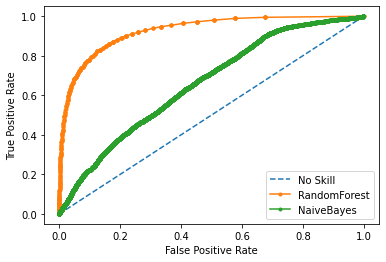

In [0]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = rf1.predict_proba(X_test)
lr_probs1 = gmodel.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs1 = lr_probs1[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lr_auc1 = roc_auc_score(y_test, lr_probs1)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF: ROC AUC=%.3f' % (lr_auc))
print('NB: ROC AUC=%.3f' % (lr_auc1))
# calculate roc curves
ns_fpr, ns_tpr, ns_thr = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, lr_thr = roc_curve(y_test, lr_probs)
lr_fpr1, lr_tpr1, lr1_thr = roc_curve(y_test, lr_probs1)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')
plt.plot(lr_fpr1, lr_tpr1, marker='.', label='NaiveBayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [0]:
lr_thr[320]

0.1075

In [0]:
lr_tpr[320]

0.8012778505897772

In [0]:
lr_tpr.sum()-(lr_tpr>0.8).sum()

109.02555701179554

Making Predictions for 2019
There are 2 cases to be tackled:

1.   Where we know the data for 2018
2.   Where we don't know the data for 2018

Since, we are only concentrating on editorial group going from non 90 to 90, for the sake of predictions, we assume all the common rows with 90's in 2018 will output zero



Case 2. In order to train for case 2 mentioned above, we drop the new variables from data_tf and try and predict for the next year, without using that year's data

In [0]:
data2tf = data_tf.drop(['Variable1new','Variable2new','newcost','cluster'],axis = 1)
kmeans1 = KMeans(n_clusters=5)
kmeans.fit(data2tf.loc[:, data2tf.columns != 'target'])
data2tf['cluster'] = kmeans.predict(data2tf.loc[:, data2tf.columns != 'target'])

X_train,X_test,y_train,y_test = train_test_split(data2tf.loc[:,data2tf.columns!='target'],data2tf['target'],test_size=0.15,random_state = 1)
rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf2.fit(X_train, y_train)
predictions = rf2.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98    102933
        True       0.77      0.30      0.43      6104

    accuracy                           0.96    109037
   macro avg       0.86      0.65      0.70    109037
weighted avg       0.95      0.96      0.95    109037



In [0]:
bestnew = 0
bestnewi = 0
for i in np.linspace(0,0.5,51):
  predictions = (rf2.predict_proba(X_test)[:,1] >= i).astype(bool)
  if(f1_score(y_test,predictions,average='macro')>best):
    bestnew = f1_score(y_test,predictions,average='macro')
    bestnewi = i

In [0]:
print(bestnew,bestnewi)

0.7725124053913048 0.3


In [0]:
predictions = (rf2.predict_proba(X_test)[:,1] >= 0.30).astype(bool)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.97      0.98      0.98    102933
        True       0.62      0.53      0.57      6104

    accuracy                           0.96    109037
   macro avg       0.80      0.75      0.77    109037
weighted avg       0.95      0.96      0.95    109037



Predictions for 2019

In [0]:
cdsfin2 = pd.merge(left = cds2018, right = cds2019, on =a,how = 'right', suffixes=('old','new'))
cdsfin2['oldcost'] = cdsfin2.Variable2old/cdsfin2.Variable1old
cdsfin2['newcost'] = cdsfin2.Variable2new/cdsfin2.Variable1new
cdsfin2.loc[cdsfin2.oldcost.isnull(),'oldcost']=0
cdsfin2.loc[cdsfin2.newcost.isnull(),'newcost']=0

In [0]:
datatf = pd.merge(left = cdsfin2, right = subjects.subject[0:92].astype('int'), on = 'subject',how = 'inner')
datatf = pd.merge(left = datatf, right = maestros, on = 'client_id',how = 'inner')


In [0]:
col_names = ['client_id', 'course', 'subject', 'type_of_material',
       'editorial_group', 'language', 'media']
for col in col_names:
    datatf[col] = datatf[col].astype('category',copy=False)

In [0]:
def cluster_predict(row):
  if row.Variable1old.isnull():
    kmeans1.predict(row.drop(['Variable1old','Variable2old','oldcost'],axis=1)
  else:
    kmeans.predict(row)

In [0]:
def final_predict(row):
  if row.Variable1old.isnull():
    rf2.predict(row.drop['Variable1old','Variable2old','costold'])
  else:
    rf1.predict(row)


In [0]:
final = datatf[datatf.editorial_group != 90]

In [0]:
final['cluster'] = 0

In [ ]:
final.loc[~final.Variable1old.isnull(),'cluster']=kmeans.predict(final[~final.Variable1old.isnull()].iloc[:,0:-1]) 

In [ ]:
for i in range(final.shape[0]):
  final.cluster[i] = cluster_predict(final.iloc[i,0:-1])

In [0]:
final.iloc[1,0:-1]

client_id                                   113956
course                                          33
subject                                         37
type_of_material                                 1
editorial_group                                  5
language                                        13
media                                            1
Variable1old                                    60
Variable2old                                1653.6
year                                          2019
Variable1new                                    60
Variable2new                                16.536
oldcost                                      27.56
newcost                                     0.2756
Latitude                                   42.8529
Longitude                                 -2.66852
Comunidad Autónoma_Comunidad Valenciana          0
Comunidad Autónoma_Islas Canarias                0
Comunidad Autónoma_La Rioja                      0
Comunidad Autónoma_Madrid      

In [0]:
cdsfin2['target']=cdsfin2.map(final_predict)

In [0]:
print("shape 2016: ", cds2016.shape)
print("shape 2017: ", cds2017.shape)
print("shape 2018: ", cds2018.shape)
print("shape 2019: ", cds2019.shape)
print()

duplicate_rows_2016 = cds2016[cds2016.duplicated()]
print("number of duplicate rows 2016: ", duplicate_rows_2016.shape)
duplicate_rows_2017 = cds2017[cds2017.duplicated()]
print("number of duplicate rows 2017: ", duplicate_rows_2017.shape)
duplicate_rows_2018 = cds2018[cds2018.duplicated()]
print("number of duplicate rows 2018: ", duplicate_rows_2018.shape)
duplicate_rows_2019 = cds2019[cds2019.duplicated()]
print("number of duplicate rows 2019: ", duplicate_rows_2019.shape)

In [0]:
def curso_cat(x):
    if x == 20 or x == 21 or x == 22 or x == 23 or x == 24 or x == 25:
        return "infantil"
    if x == 26 or x == 27 or x == 28 or x == 29 or x == 30 or x == 31:
        return "primaria"
    if x == 32 or x == 33 or x == 34 or x == 35:
        return "secundaria"
    if x == 36 or x == 37:
        return "bachillerato"

In [0]:
cds2016["course"] = cds2016["course"].map(curso_cat)
cds2017["course"] = cds2017["course"].map(curso_cat)
cds2018["course"] = cds2018["course"].map(curso_cat)
cds2019["Curso"] = cds2019["Curso"].map(curso_cat)

In [0]:
cds2016["subject"] = cds2016["subject"].map(asignatura_cat)
cds2017["subject"] = cds2017["subject"].map(asignatura_cat)
cds2018["subject"] = cds2018["subject"].map(asignatura_cat)
cds2019["Asignatura"] = cds2019["Asignatura"].map(asignatura_cat)

In [0]:
def TME_cat(x):
    if x == 1:
        return "básico"
    if x == 2:
        return "complementario"
    if x == 3:
        return "cuaderno asociado"
    if x == 4:
        return "prescribible"

In [0]:
cds2016["type_of_material"] = cds2016["type_of_material"].map(TME_cat)
cds2017["type_of_material"] = cds2017["type_of_material"].map(TME_cat)
cds2018["type_of_material"] = cds2018["type_of_material"].map(TME_cat)
cds2019["Tipo Material Educativo"] = cds2019["Tipo Material Educativo"].map(TME_cat)

In [0]:
def lengua_cat(x):
    if x == 10:
        return "Catalán"
    if x == 11:
        return "Gallego"
    if x == 13:
        return "Castellano"
    if x == 18:
        return "Valenciano"
    if x == 26:
        return "Euskera"

In [0]:
cds2016["Lengua"] = cds2016["Lengua"].map(lengua_cat)
cds2017["Lengua"] = cds2017["Lengua"].map(lengua_cat)
cds2018["Lengua"] = cds2018["Lengua"].map(lengua_cat)
cds2019["Lengua"] = cds2019["Lengua"].map(lengua_cat)

In [0]:
def TS_cat(x):
    if x == 1:
        return "papel"
    if x == 2:
        return "digital"
    if x == 3:
        return "papel-digital"
    if x == 4:
        return "plataforma"

In [0]:
cds2016["Tipo Soporte Actual"] = cds2016["Tipo Soporte Actual"].map(TS_cat)
cds2017["Tipo Soporte Actual"] = cds2017["Tipo Soporte Actual"].map(TS_cat)
cds2018["Tipo Soporte Actual"] = cds2018["Tipo Soporte Actual"].map(TS_cat)
cds2019["Tipo Soporte Actual"] = cds2019["Tipo Soporte Actual"].map(TS_cat)

In [0]:
cds2016.iloc[:,0:-2] = cds2016.iloc[:,0:-2].astype('category')

In [0]:
cds1 = pd.merge(left = cds2016,right = cds2017, on = a, how='right',suffixes=('2016','2017'))

In [0]:
cds2 = pd.merge(left = cds1,right = cds2018, on = a, how='inner')

In [0]:
cds = cds2[cds2.editorial_group2016.isnull()]
cds = cds[cds.editorial_group2017!=90]

In [0]:
cds['target'] = (cds.editorial_group == 90)

In [0]:
cds = cds.drop(['editorial_group2016','Variable12016','Variable22016','editorial_group','Variable1','Variable2'],axis = 1)

In [0]:
cds.course = cds2018.course.map(course_seg)
cds['cost'] = cds.Variable22017/cds.Variable12017
cds.loc[cds.cost.isnull(),'cost']=0
col_names = ['client_id', 'course', 'subject', 'type_of_material','editorial_group2017', 'language', 'media']
for col in col_names:
    cds[col] = cds[col].astype('category',copy=False)
cds_tf = pd.merge(left = cds, right = subjects.subject[0:92].astype('int'), on = 'subject',how = 'inner')
cds_tf = pd.merge(left = cds_tf, right = maestros, on = 'client_id',how = 'inner')
X_train,X_test,y_train,y_test = train_test_split(cds_tf.loc[:,cds_tf.columns!='target'],cds_tf['target'],test_size=0.15,random_state = 1)
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 15)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.95      1.00      0.97      8497
        True       0.89      0.14      0.25       525

    accuracy                           0.95      9022
   macro avg       0.92      0.57      0.61      9022
weighted avg       0.95      0.95      0.93      9022



In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
X_train = cds_tf.loc[:,cds_tf.columns!='target']
y_train = cds_tf['target']
rf = RandomForestClassifier(random_state = 42)

In [ ]:
rsearch = RandomizedSearchCV(rf, random_grid, cv = 5,scoring = "f1_macro",n_iter=400)
rsearch.fit(X_train, y_train)
rsearch.best_params_